In [1]:
import numpy as np
import pandas as pd
from functools import reduce
import pathlib
import matplotlib.pyplot as plt
import gzip
import scipy.sparse as sparse

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Define the figure size and dpi
fig_width = 6.9  # inches
fig_height = 3.5  # inches
fig_dpi = 350

plt.rcParams.update({
    'figure.figsize': (fig_width, fig_height),
    'figure.dpi': fig_dpi,

    # Fonts
    'font.size': 12,

    # Axes
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'axes.linewidth': 1,
    'axes.grid': True,
    'grid.linestyle': ':',
    'grid.linewidth': 1,
    'grid.color': 'gray',

    # Legend
    'legend.fontsize': 8,
    'legend.frameon': True,
    'legend.framealpha': 0.8,
    'legend.fancybox': False,
    'legend.edgecolor': 'gray',
    'legend.facecolor': 'white',
    'legend.borderaxespad': 0.5,
    'legend.borderpad': 0.4,
    'legend.labelspacing': 0.5,

    # Lines
    'lines.linewidth': 2.0,
    'lines.markersize': 2,
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
})

In [2]:
def get_root_models(path_models:pathlib.Path):
    dfs = []
    for entry in path_models.iterdir():
        # check if it is a root model
        if "root" in entry.as_posix():
            # Path to the root model
            path = entry

            # Thr and exp_tpc do not apply for the root model
            thr = -1
            exp_tpc = -1

            # Experiment iteration
            iter_ = int(entry.as_posix().split("model_")[1].split("_")[0])

            # Size of the topics
            alphas = np.load(path.joinpath('TMmodel/alphas.npy')).tolist()

            # Coherences (CV and NPMI)
            cohrs_cv = np.load(path.joinpath('TMmodel/topic_coherence.npy')).tolist()
            cohrs_npmi = np.load(path.joinpath('TMmodel/new_topic_coherence.npy'), allow_pickle=True).tolist()
            #if len(cohrs) > len(alphas):
            #    cohrs_cv = cohrs[0:len(alphas)]
            #    cohrs_npmi = cohrs[len(alphas):]
            #elif len(cohrs) == len(alphas):
            #    cohrs_cv = cohrs
            #    cohrs_npmi = [0] * len(alphas)

            # Topics' entropies
            entropies = np.load(path.joinpath('TMmodel/topic_entropy.npy')).tolist()

            # TD
            td = np.load(path.joinpath('TMmodel/td.npy'))

            # IRBO 
            rbo = np.load(path.joinpath('TMmodel/rbo.npy'))
            
            # tpc_Desc
            with path.joinpath('TMmodel/tpc_descriptions.txt').open('r', encoding='utf8') as fin:
                tpc_descriptions = [el.strip() for el in fin.readlines()]

            # Ids of the topics
            tpc_ids = np.arange(0,len(alphas),1)

            # Corpus size
            if path.joinpath('corpus.txt').is_file():
                corpus = [line.rsplit(' 0 ')[1].strip() for line in open(
                    path.joinpath('corpus.txt'), encoding="utf-8").readlines()]
                size = len(corpus)
            elif path.joinpath('corpus.parquet').is_dir():
                dfc = pd.read_parquet(path.joinpath('corpus.parquet'))
                size = len(dfc)

            # Create dataframe for the root model
            root_tpc_df = pd.DataFrame(
                {'iter': [iter_] * len(alphas),
                 'path': [path] * len(alphas),
                 'cohrs_cv': cohrs_cv,
                 'cohrs_npmi': cohrs_npmi,
                 'entropies': entropies,
                 'td': [td] * len(alphas),
                 'rbo': [rbo] * len(alphas),
                 'alphas': alphas,
                 'tpc_ids': tpc_ids,
                 'thr': [thr] * len(alphas),
                 'exp_tpc': [exp_tpc] * len(alphas),
                 'tr_tpcs': [0] * len(alphas),
                 'tpc_descriptions': tpc_descriptions
                })

            # Append to the list of dataframes to concatenate them
            dfs.append(root_tpc_df)
    df = pd.concat(dfs)
    df = df.sort_values(by=['iter'])
    
    if df.iloc[0].path.joinpath('corpus.txt').is_file():
        corpus = [line.rsplit(' 0 ')[1].strip() for line in open(
                    df.iloc[0].path.joinpath('corpus.txt'), encoding="utf-8").readlines()]
        root_size = len(corpus)
    elif df.iloc[0].path.joinpath('corpus.parquet').is_dir() or df.iloc[0].path.joinpath('corpus.parquet').is_file():
        dfc = pd.read_parquet(df.iloc[0].path.joinpath('corpus.parquet'))
        root_size = len(dfc)    
    return df, root_size


def get_submodules(df:pd.DataFrame):
    # Iter over each root model (according to its corresponding iteration, iter)
    concats = [df]
    not_finished = []
    for el in df.iter.unique():
        path_root = df[df.iter == el].iloc[0].path
        for entry in path_root.iterdir():
            if entry.joinpath('TMmodel/topic_coherence.npy').is_file() and not entry.as_posix().endswith("old"):

                try:
                    if "ws" in entry.as_posix():
                        thr = 0
                        size = 0
                    else:
                        thr = float(entry.as_posix().split("thr_")[1].split("_")[0])

                        if entry.joinpath('corpus.txt').is_file():
                            corpus = [line.rsplit(' 0 ')[1].strip() for line in open(
                                        entry.joinpath('corpus.txt'), encoding="utf-8").readlines()]
                            size = len(corpus)
                        elif entry.joinpath('corpus.parquet').is_dir():
                            dfc = pd.read_parquet(entry.joinpath('corpus.parquet'))
                            size = len(dfc)
                        size = size * 100 / root_size

                    # get topic from which the submodel is generated
                    exp_tpc = int(entry.as_posix().split("from_topic_")[1].split("_")[0])


                    # Size of the topics
                    alphas = np.load(entry.joinpath('TMmodel/alphas.npy')).tolist()

                    # Alphas submodel is the mean of the cohr of its topics
                    alpha = np.mean(alphas)

                    # Coherences (CV and NPMI)
                    cohrs_cv = np.load(entry.joinpath('TMmodel/topic_coherence.npy')).tolist()
                    cohrs_npmi = np.load(entry.joinpath('TMmodel/new_topic_coherence.npy'), allow_pickle=True).tolist()
                    if cohrs_npmi is None:
                        cohrs_npmi = [0]*len(cohrs_cv)
                        print(entry)
                    #if len(cohrs) > len(alphas):
                    #    cohrs_cv = cohrs[0:len(alphas)]
                    #    cohrs_npmi = cohrs[len(alphas):]
                    #elif len(cohrs) == len(alphas):
                    #    cohrs_cv = cohrs
                    #    cohrs_npmi = [0] * len(alphas)

                    # cohr submodel is the mean of the cohr of its topics
                    cohr_cv = np.mean(cohrs_cv)
                    cohr_npmi = np.mean(cohrs_npmi)

                    # TD
                    td = np.load(entry.joinpath('TMmodel/td.npy'))

                    # IRBO 
                    rbo = np.load(entry.joinpath('TMmodel/rbo.npy'))

                    # Topics' entropies
                    entropy = np.mean(np.load(entry.joinpath('TMmodel/topic_entropy.npy')).tolist())

                    tr_tpcs = int(entry.as_posix().split("train_with_")[1].split("_")[0])
                    
                    # tpc_Desc
                    with entry.joinpath('TMmodel/tpc_descriptions.txt').open('r', encoding='utf8') as fin:
                        tpc_descriptions = [el.strip() for el in fin.readlines()]

                    # add entry of submodel to dataframe
                    root_tpc_df = pd.DataFrame(
                    {'iter': [el],
                     'path': [entry],
                     'cohrs_cv': [cohr_cv],
                     'cohrs_npmi': [cohr_npmi],
                     'entropies': [entropy],
                     'alphas': [alpha],
                     'td': [td],
                     'rbo': [rbo],
                     'tpc_ids': [exp_tpc],
                     'thr': [thr],
                     'exp_tpc': [exp_tpc],
                     'size': [size],
                     'tr_tpcs': [tr_tpcs],
                     'tpc_descriptions': [tpc_descriptions]
                    })
                    concats.append(root_tpc_df)

                except:
                    not_finished.append(entry)

            else:
                not_finished.append(entry)
    df = pd.concat(concats)
    
    return df

def get_df_all_models(path_models:pathlib.Path):
    df_root, root_size = get_root_models(path_models)
    df_all = get_submodules(df_root)
    return df_all, root_size

In [3]:
path_models_mallet = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Datasets/CORDIS/htm_var_topics_mallet")
path_models_ctm = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Datasets/CORDIS/htm_var_topics_ctm")

folder_save = "images/graphs_12sept"
corpus_name = "Cordis"

# MALLET

In [4]:
model_type = "mallet"
df_mallet, root_size = get_df_all_models(path_models_mallet)

## Root models

In [5]:
df_root_mallet = df_mallet[df_mallet.thr==-1]

In [26]:
df1 = df_root_mallet.groupby('tpc_ids')[['cohrs_cv', 'cohrs_npmi', 'entropies', 'alphas', 'td', 'rbo']].mean()
df1 = df1.rename(columns={'cohrs_cv': 'cohrs_cv_mean',
                          'cohrs_npmi': 'cohrs_npmi_mean',
                          'entropies': 'entropies_mean',
                          'alphas': 'alphas_mean',
                         })

df2 = df_root_mallet.groupby('tpc_ids')[['cohrs_cv', 'cohrs_npmi', 'entropies', 'td', 'rbo']].var()
df2 = df2.rename(columns={'cohrs_cv': 'cohrs_cv_var',
                          'cohrs_npmi': 'cohrs_npmi_var',
                          'entropies': 'entropies_var',
                         })

df_root_plot_mallet = pd.concat([df1, df2], axis=1, join='inner')

df_root_plot_mallet['tpc_ids'] = np.arange(0,len(df_root_plot_mallet),1)
df_root_plot_mallet['td'] =  [df_root_mallet['td'].values[0].tolist()]*len(df_root_plot_mallet)
df_root_plot_mallet['rbo'] =  [df_root_mallet['rbo'].values[0].tolist()]*len(df_root_plot_mallet)
df_root_plot_mallet

cohrs_cv_mean  cohrs_npmi_mean  entropies_mean  alphas_mean  \
tpc_ids                                                                
0             0.615635         0.068360        0.752374     0.255330   
1             0.546475         0.037314        0.761661     0.252668   
2             0.790402         0.112431        0.760219     0.200007   
3             0.640263         0.073220        0.769471     0.185179   
4             0.663521         0.093825        0.747615     0.106817   

         cohrs_cv_var  cohrs_npmi_var  entropies_var  tpc_ids        td  \
tpc_ids                                                                   
0                 0.0             0.0            0.0        0  0.933333   
1                 0.0             0.0            0.0        1  0.933333   
2                 0.0             0.0            0.0        2  0.933333   
3                 0.0             0.0            0.0        3  0.933333   
4                 0.0             0.0            0.0        4  0.933333   

              rbo  
tpc_ids            
0        0.972898  
1        0.972898  
2        0.972898  
3        0.972898  
4        0.972898

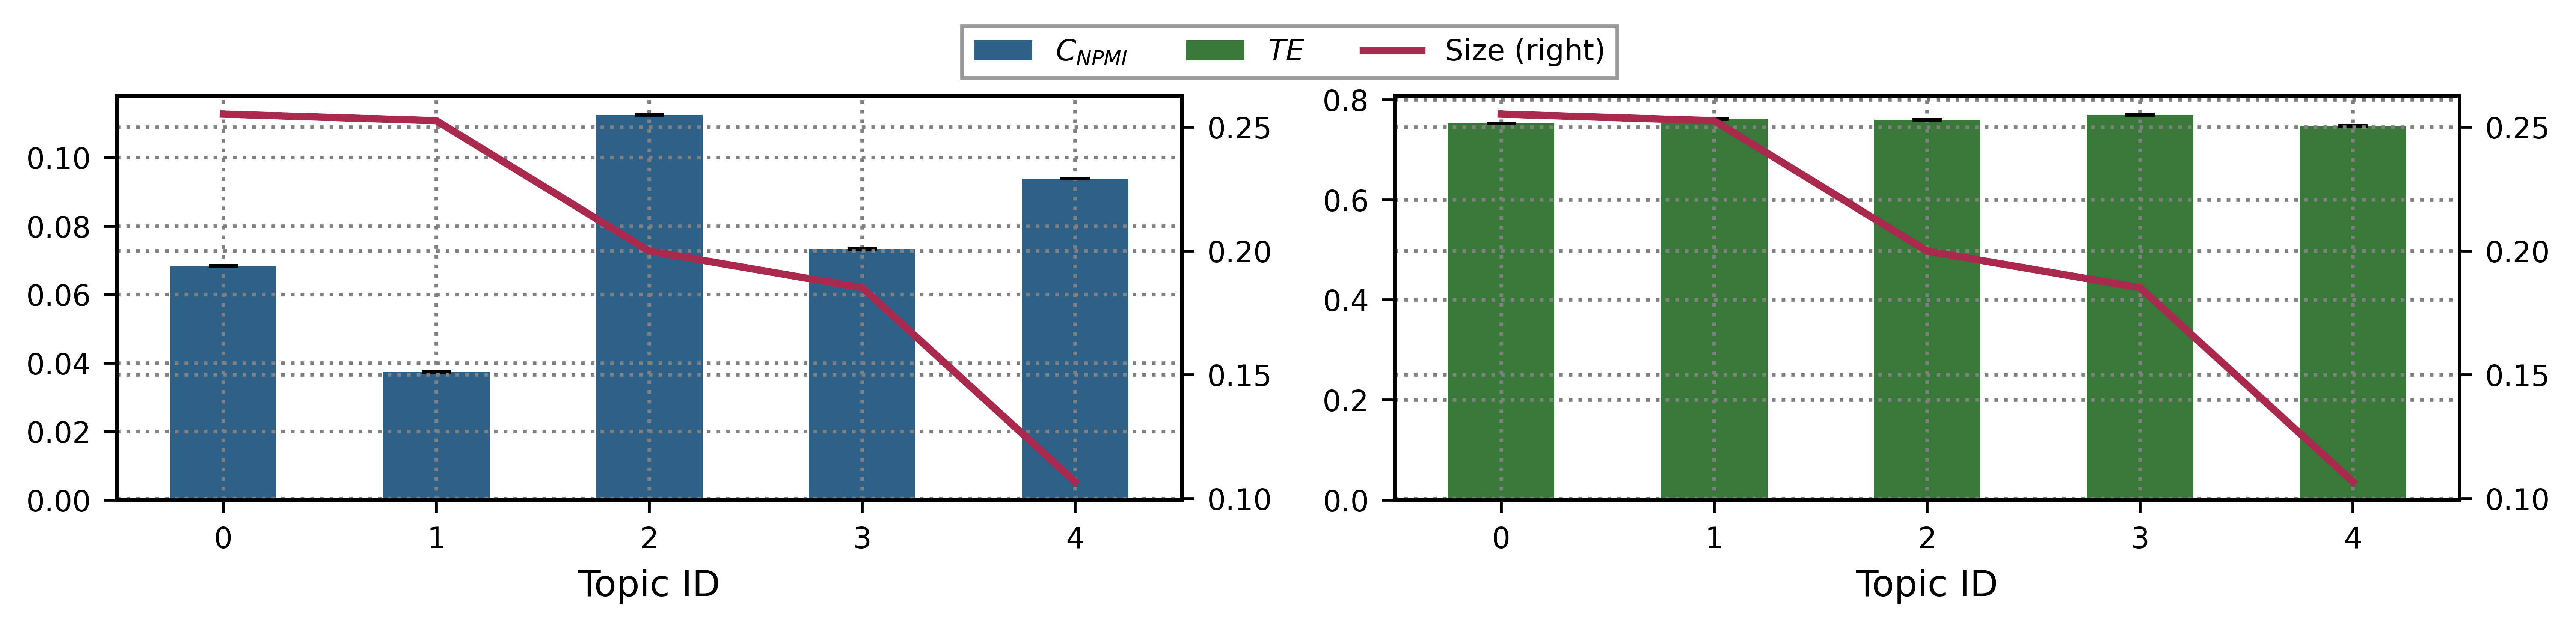

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (11.5, 2)) 
y_repr = ['cohrs_npmi', 'entropies']
y_labels = ['$C_{NPMI}$', '$TE$']
colors = ["#2D6187",  "#387838"] 
labels_all = []
handles_all = []
for yrepr, ylabel, color, ax in zip(y_repr, y_labels, colors, axs.flat):
    
    df_root_plot_mallet.plot.bar(
        ax=ax,
        y=yrepr + "_mean",
        yerr = yrepr + "_var",
        label=ylabel, use_index=True, stacked=True,
        color = color,
        capsize=4)
    ax2 = df_root_plot_mallet.plot(
            ax=ax, 
            y='alphas_mean', kind = 'line', label='Size', color="#A9294F", use_index=True, secondary_y=True)

    ax.grid(True)
    ax.set_xlabel('Topic ID')
    ax2.grid(True)
    ax.get_legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    labels_all += labels
    handles_all += handles

handles2, labels2 = ax2.get_legend_handles_labels()

fig.legend(handles_all+handles2, labels_all+labels2, loc='upper center', ncol=4, bbox_to_anchor=(0.513, 1.04),
           frameon=True, shadow=False)

save_fig = folder_save + "/root_model_" + corpus_name + "_" + model_type + ".png"
fig.savefig(save_fig, dpi='figure', bbox_inches='tight')

In [27]:
df_mallet_root_tpcs = pd.DataFrame(data=df_root_mallet.tpc_descriptions.unique(),
                                   index=range(len(df_root_mallet.tpc_descriptions.unique())),
                                   columns=['Tpc description'])
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       'display.max_colwidth',None
                       ):
    display(df_mallet_root_tpcs)

Tpc description
0          market, industry, service, manufacture, company, business, customer, safety, sme, software, aircraft, security, waste, operation, smart
1    policy, politic, service, stakeholders, national, innovation, sme, culture, language, governance, theory, public, education, city, healthcare
2                  cell, cancer, patient, protein, therapy, genetic, disease, brain, tumor, vivo, molecule, neuron, drug, tissue, ribonucleic_acid
3  quantum, theory, molecule, physics, photonic, chemistry, electronic, optical, catalysis, magnetic, surface, electron, geometry, image, graphene
4            plant, climate, food, specie, soil, climate_change, genetic, water, crop, biodiversity, agriculture, ocean, forest, ecosystem, genome

## HTM-WS Submodels

In [28]:
df_ws_mallet = df_mallet[df_mallet.thr==0]
df_ws_mallet

iter                                               path  cohrs_cv  \
0      1  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.705187   
0      1  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.707365   
0      1  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.692747   
0      1  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.689019   
0      1  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.686190   
..   ...                                                ...       ...   
0      5  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.644159   
0      5  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.685108   
0      5  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.687702   
0      5  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.642904   
0      5  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.671958   

    cohrs_npmi  entropies                  td                 rbo    alphas  \
0     0.089559   0.622013  0.6883333333333334  0.9775061744997643  0.025000   
0     0.148107   0.750971                0.88   0.955950900950901  0.199999   
0     0.084495   0.602551               0.632  0.9779209140066283  0.020000   
0     0.086186   0.588267  0.6044444444444445  0.9787696177018211  0.016667   
0     0.077909   0.577351                0.58  0.9785379960887207  0.014286   
..         ...        ...                 ...                 ...       ...   
0     0.073808   0.747343  0.9066666666666666   0.961517279017279  0.200001   
0     0.054057   0.581944  0.6626666666666666  0.9794579153273031  0.020000   
0     0.054266   0.560701  0.6355555555555555  0.9801853584791438  0.016667   
0     0.072453   0.555890              0.6375  0.9762887310181614  0.012500   
0     0.042423   0.552631  0.6095238095238096  0.9797301846225241  0.014286   

    tpc_ids  thr  exp_tpc  tr_tpcs  \
0         4    0        4       40   
0         0    0        0        5   
0         4    0        4       50   
0         4    0        4       60   
0         4    0        4       70   
..      ...  ...      ...      ...   
0         2    0        2        5   
0         2    0        2       50   
0         2    0        2       60   
0         0    0        0       80   
0         2    0        2       70   

                                     tpc_descriptions  size  
0   [simulation, performance, test, evaluation, mo...   0.0  
0   [patient, diagnosis, biomarker, cancer, treatm...   0.0  
0   [validation, test, performance, validate, eval...   0.0  
0   [high, market, low, require, industry, grow, s...   0.0  
0   [concept, integrate, integration, objective, r...   0.0  
..                                                ...   ...  
0   [food, water, aquaculture, sustainability, was...   0.0  
0   [data, estimation, information, uncertainty, s...   0.0  
0   [interaction, change, environment, understandi...   0.0  
0   [identify, molecule, pathway, understanding, b...   0.0  
0   [skill, expertise, field, lead, applicant, car...   0.0  

[225 rows x 14 columns]

In [29]:
def my_agg(x):
    names = {
        'cohrs_cv_mean': x['cohrs_cv'].mean(),
        'cohrs_npmi_mean': x['cohrs_npmi'].mean(),
        'entropies_mean':x['entropies'].mean(),
        'alphas_mean':x['alphas'].mean(),
        'td_mean':x['td'].mean(),
        'rbo_mean':x['rbo'].mean(),
        'cohrs_cv_var':x['cohrs_cv'].std(),
        'cohrs_npmi_var':x['cohrs_npmi'].std(),
        'entropies_var':x['entropies'].std(),
        'alphas_var':x['alphas'].std(),
        'td_var':x['td'].std(),
        'rbo_var':x['rbo'].std()}

    return pd.Series(names, index=['cohrs_cv_mean', 'cohrs_npmi_mean','entropies_mean', 'alphas_mean', 'td_mean', 'rbo_mean',
                                   'cohrs_cv_var', 'cohrs_npmi_var','entropies_var', 'alphas_var', 'td_var', 'rbo_var'])

df_ws_mallet_plot = df_ws_mallet.groupby(['exp_tpc', 'tr_tpcs'], as_index=False).apply(my_agg)
df_ws_mallet_plot

exp_tpc  tr_tpcs  cohrs_cv_mean  cohrs_npmi_mean  entropies_mean  \
0         0        5       0.683668         0.145467        0.750386   
1         0       10       0.654540         0.121993        0.714500   
2         0       20       0.658444         0.108920        0.672429   
3         0       30       0.655164         0.099435        0.644337   
4         0       40       0.648315         0.089796        0.622041   
5         0       50       0.642833         0.084796        0.600314   
6         0       60       0.651958         0.085757        0.581685   
7         0       70       0.637407         0.073116        0.568831   
8         0       80       0.631226         0.066887        0.556447   
9         1        5       0.645473         0.090354        0.758359   
10        1       10       0.729631         0.119510        0.721343   
11        1       20       0.708829         0.096133        0.682839   
12        1       30       0.709635         0.090721        0.659550   
13        1       40       0.691034         0.080418        0.637959   
14        1       50       0.683062         0.069824        0.619728   
15        1       60       0.679529         0.066089        0.605698   
16        1       70       0.670499         0.058496        0.593769   
17        1       80       0.660755         0.053163        0.583285   
18        2        5       0.638238         0.065100        0.749797   
19        2       10       0.697386         0.089562        0.714970   
20        2       20       0.715619         0.091064        0.663953   
21        2       30       0.711841         0.080226        0.626559   
22        2       40       0.699943         0.065105        0.600390   
23        2       50       0.690457         0.057447        0.581242   
24        2       60       0.687076         0.052067        0.563121   
25        2       70       0.666831         0.038475        0.551200   
26        2       80       0.665324         0.035045        0.537511   
27        3        5       0.692688         0.105739        0.764158   
28        3       10       0.742575         0.126856        0.730542   
29        3       20       0.755960         0.125193        0.690475   
30        3       30       0.745390         0.116111        0.659595   
31        3       40       0.739351         0.107507        0.633421   
32        3       50       0.724690         0.097986        0.614271   
33        3       60       0.721483         0.092171        0.598456   
34        3       70       0.708761         0.080537        0.585768   
35        3       80       0.703782         0.074434        0.573468   
36        4        5       0.697898         0.116743        0.747528   
37        4       10       0.697694         0.100602        0.714651   
38        4       20       0.703957         0.093126        0.674737   
39        4       30       0.704683         0.093762        0.644840   
40        4       40       0.694792         0.088680        0.621146   
41        4       50       0.692660         0.086652        0.603378   
42        4       60       0.681487         0.082888        0.588961   
43        4       70       0.681827         0.080005        0.577781   
44        4       80       0.668062         0.072556        0.567248   

    alphas_mean   td_mean  rbo_mean  cohrs_cv_var  cohrs_npmi_var  \
0      0.199999  0.909333  0.960327      0.033444        0.006732   
1      0.100000  0.868000  0.955729      0.006899        0.003226   
2      0.050000  0.785333  0.966773      0.024674        0.010215   
3      0.033333  0.744444  0.967930      0.009893        0.009572   
4      0.025000  0.720000  0.970197      0.013645        0.006943   
5      0.020000  0.705867  0.973134      0.010059        0.004735   
6      0.016667  0.668222  0.971492      0.010275        0.006902   
7      0.014286  0.655429  0.974026      0.006424        0.005811   
8      0.012500  0.646833  0.975430      0.009044        0.004482   
9

In [30]:
my_xticks = df_ws_mallet_plot.tr_tpcs.unique().tolist()
my_xticks

[5, 10, 20, 30, 40, 50, 60, 70, 80]

## Final graphs

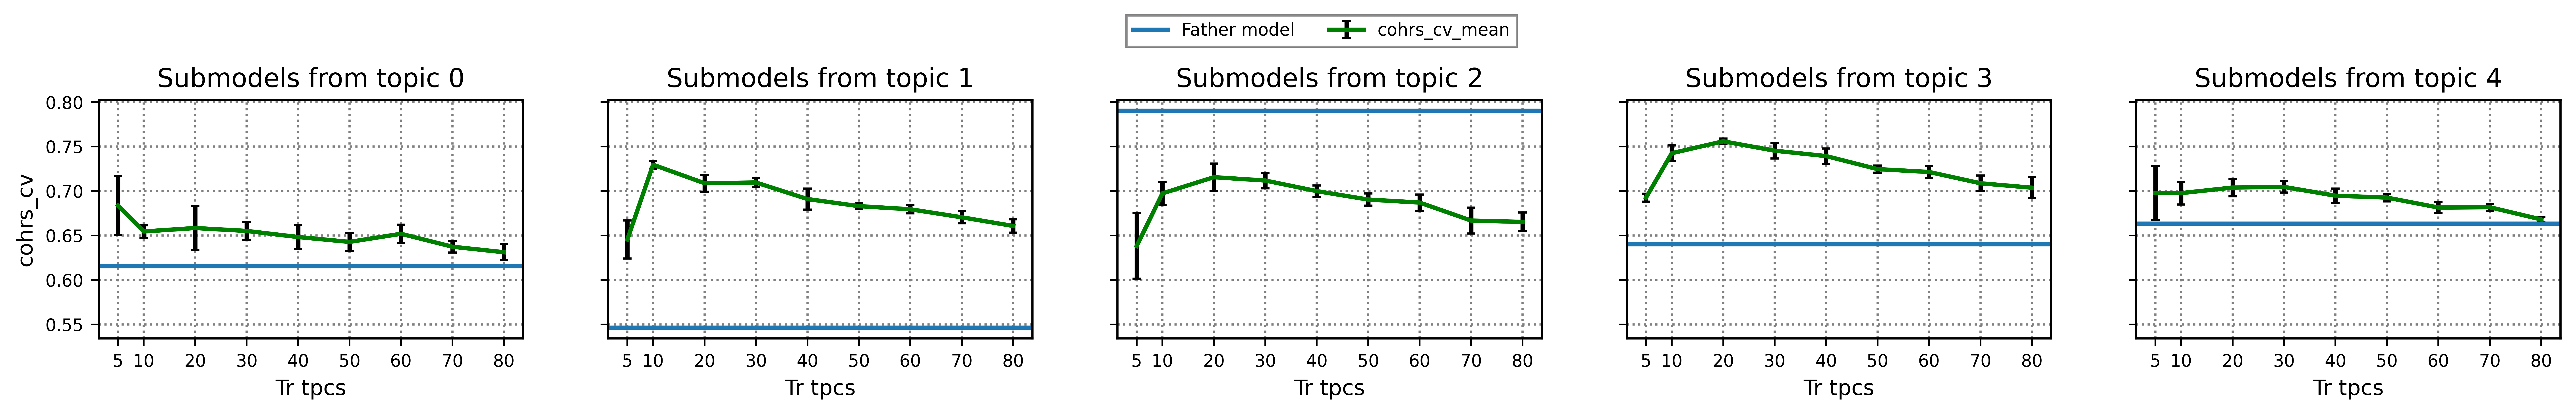

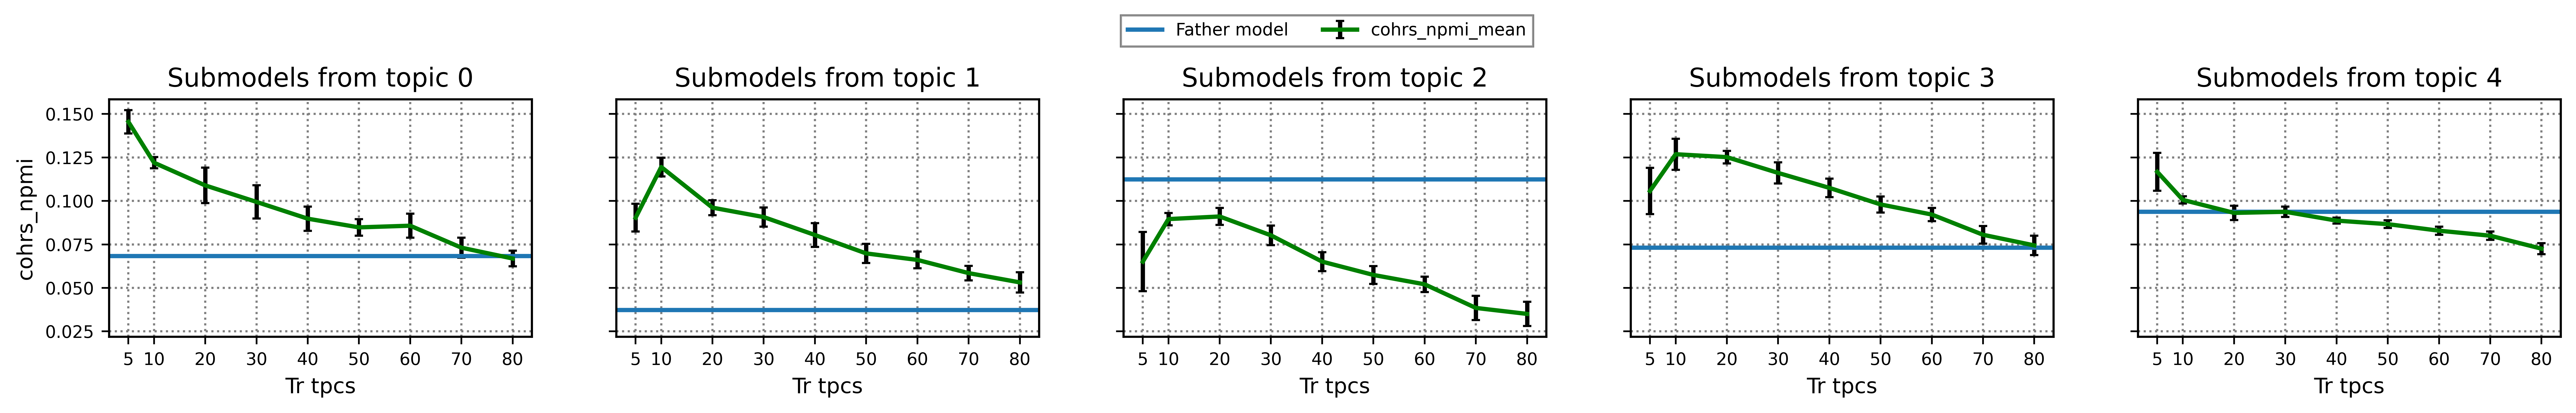

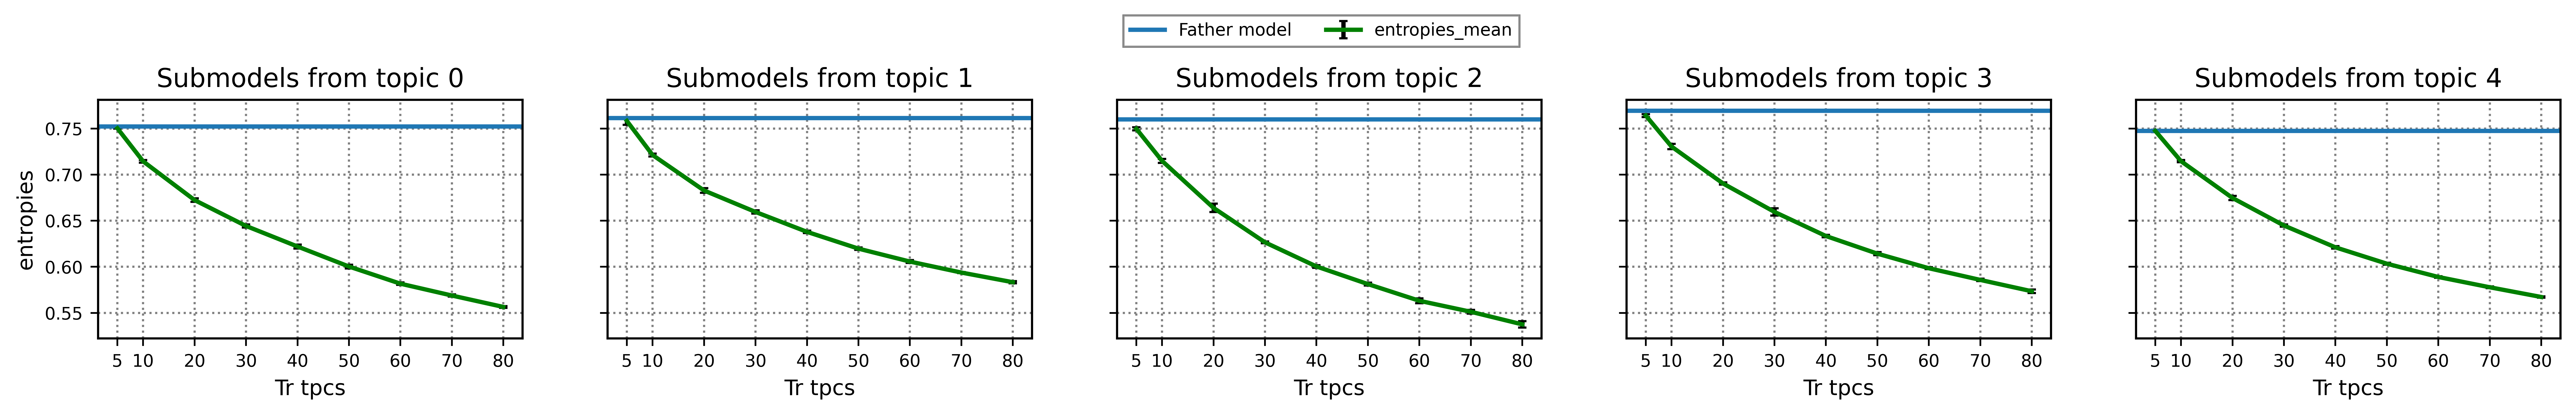

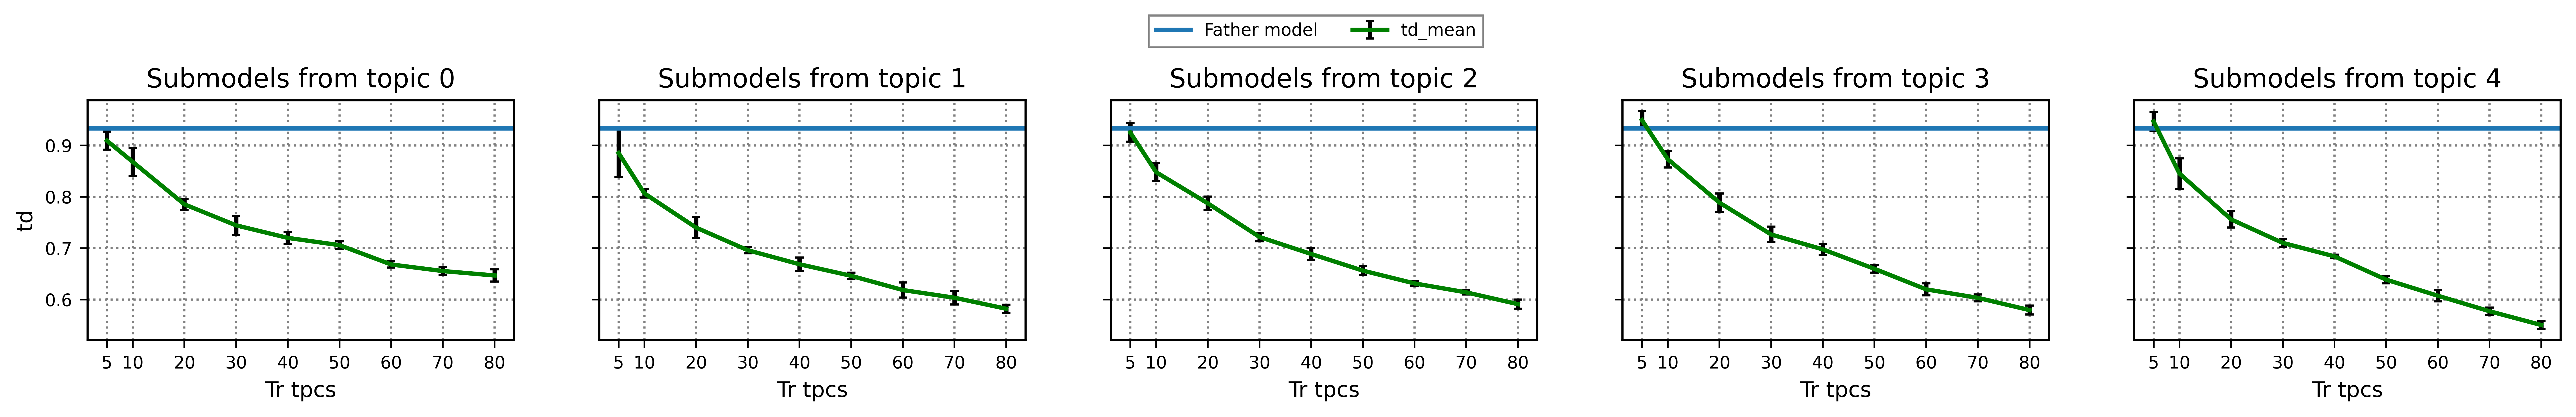

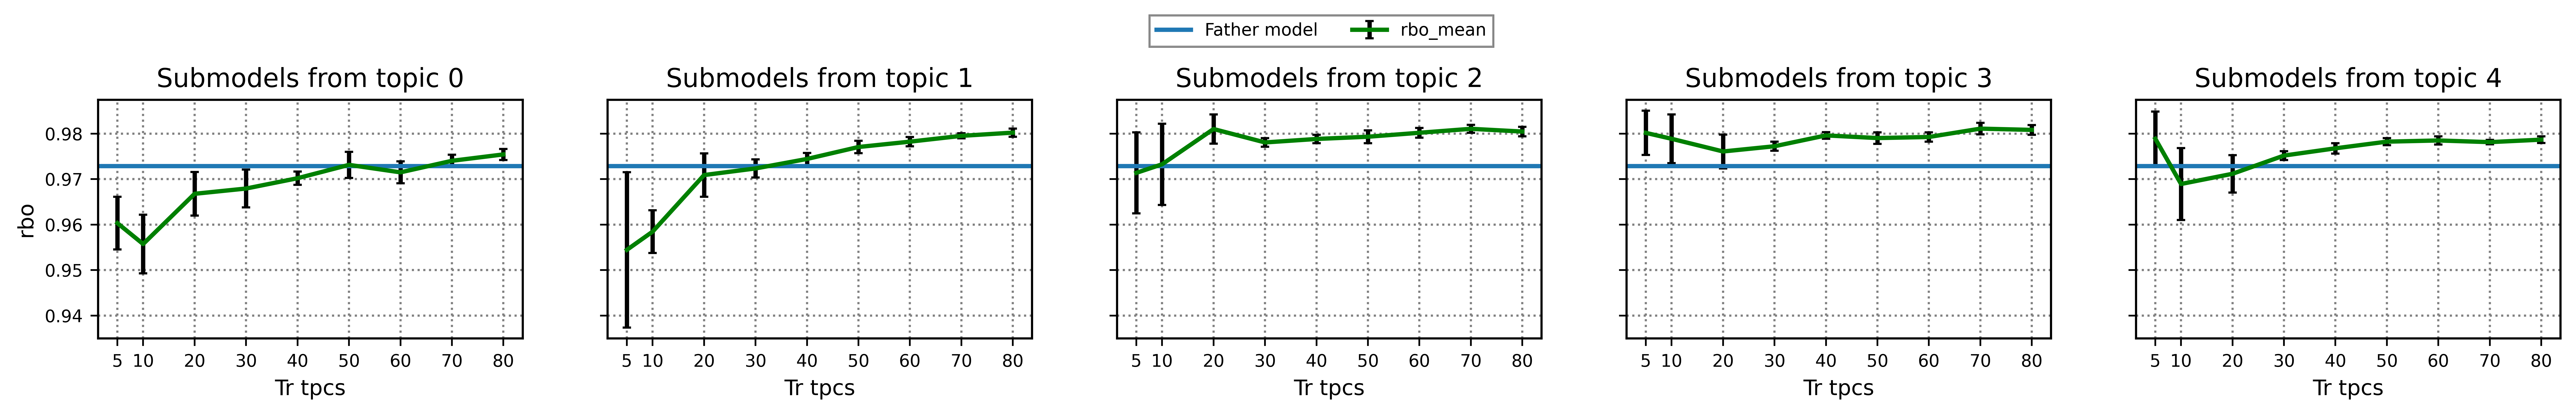

In [32]:
metrics = ['cohrs_cv', 'cohrs_npmi', 'entropies', 'td', 'rbo']
for metric in metrics:
    metric_y = metric + '_mean'
    metric_y_root = metric + '_mean' if metric not in ['td', 'rbo'] else metric
    metric_y_err = metric + '_var'
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize = (20.5, 2), sharex=True, sharey=True) # for 5 topics: (25.5, 4.8)
    for tpc, ax in zip(sorted(df_ws_mallet_plot.exp_tpc.unique()), axs.flat):
        aux = df_ws_mallet_plot[df_ws_mallet_plot.exp_tpc == tpc]
        aux.plot(
            ax=ax,
            x='tr_tpcs',
            y=metric_y,
            yerr=metric_y_err,
            color='green',
            ecolor='black',
            linewidth=2, 
            capsize=2,
            rot=0,
            kind='line'  
        )
        y_ = df_root_plot_mallet[df_root_plot_mallet.tpc_ids==tpc][metric_y_root].values[0]
        if isinstance(y_, np.ndarray):
            y_ = y_.tolist()[0]
        ax.axhline(y=y_, xmin=-1, xmax=len(my_xticks), label='Father model')
        ax.get_legend().remove()
        ax.set_xticks(my_xticks)
        ax.set_xlabel('Tr tpcs')
        ax.set_ylabel(metric)
        ax.set_title(f'Submodels from topic {tpc}')
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.51, 1.18),
                  frameon=True, shadow=False)

# CTM

In [33]:
model_type = "ctm"
df_ctm, root_size = get_df_all_models(path_models_ctm)

## Root models

In [34]:
df_root_ctm = df_ctm[df_ctm.thr==-1]

In [35]:
df1 = df_root_ctm.groupby('tpc_ids')[['cohrs_cv', 'cohrs_npmi', 'entropies', 'alphas', 'td', 'rbo']].mean()
df1 = df1.rename(columns={'cohrs_cv': 'cohrs_cv_mean',
                          'cohrs_npmi': 'cohrs_npmi_mean',
                          'entropies': 'entropies_mean',
                          'alphas': 'alphas_mean',
                         })

df2 = df_root_ctm.groupby('tpc_ids')[['cohrs_cv', 'cohrs_npmi', 'entropies', 'td', 'rbo']].var()
df2 = df2.rename(columns={'cohrs_cv': 'cohrs_cv_var',
                          'cohrs_npmi': 'cohrs_npmi_var',
                          'entropies': 'entropies_var',
                         })

df_root_plot_ctm = pd.concat([df1, df2], axis=1, join='inner')

df_root_plot_ctm['tpc_ids'] = np.arange(0,len(df_root_plot_ctm),1)
df_root_plot_ctm['td'] =  [df_root_ctm['td'].values[0].tolist()]*len(df_root_plot_mallet)
df_root_plot_ctm['rbo'] =  [df_root_ctm['rbo'].values[0].tolist()]*len(df_root_plot_mallet)
df_root_plot_ctm

cohrs_cv_mean  cohrs_npmi_mean  entropies_mean  alphas_mean  \
tpc_ids                                                                
0             0.475596         0.057231        0.999774     0.215819   
1             0.650983         0.107623        0.999761     0.205970   
2             0.784461         0.125837        0.999762     0.199456   
3             0.513422        -0.331804        0.999488     0.197160   
4             0.612029         0.086470        0.999784     0.181595   

         cohrs_cv_var  cohrs_npmi_var  entropies_var  tpc_ids   td  rbo  
tpc_ids                                                                  
0                 0.0             0.0            0.0        0  1.0  1.0  
1                 0.0             0.0            0.0        1  1.0  1.0  
2                 0.0             0.0            0.0        2  1.0  1.0  
3                 0.0             0.0            0.0        3  1.0  1.0  
4                 0.0             0.0            0.0        4  1.0  1.0

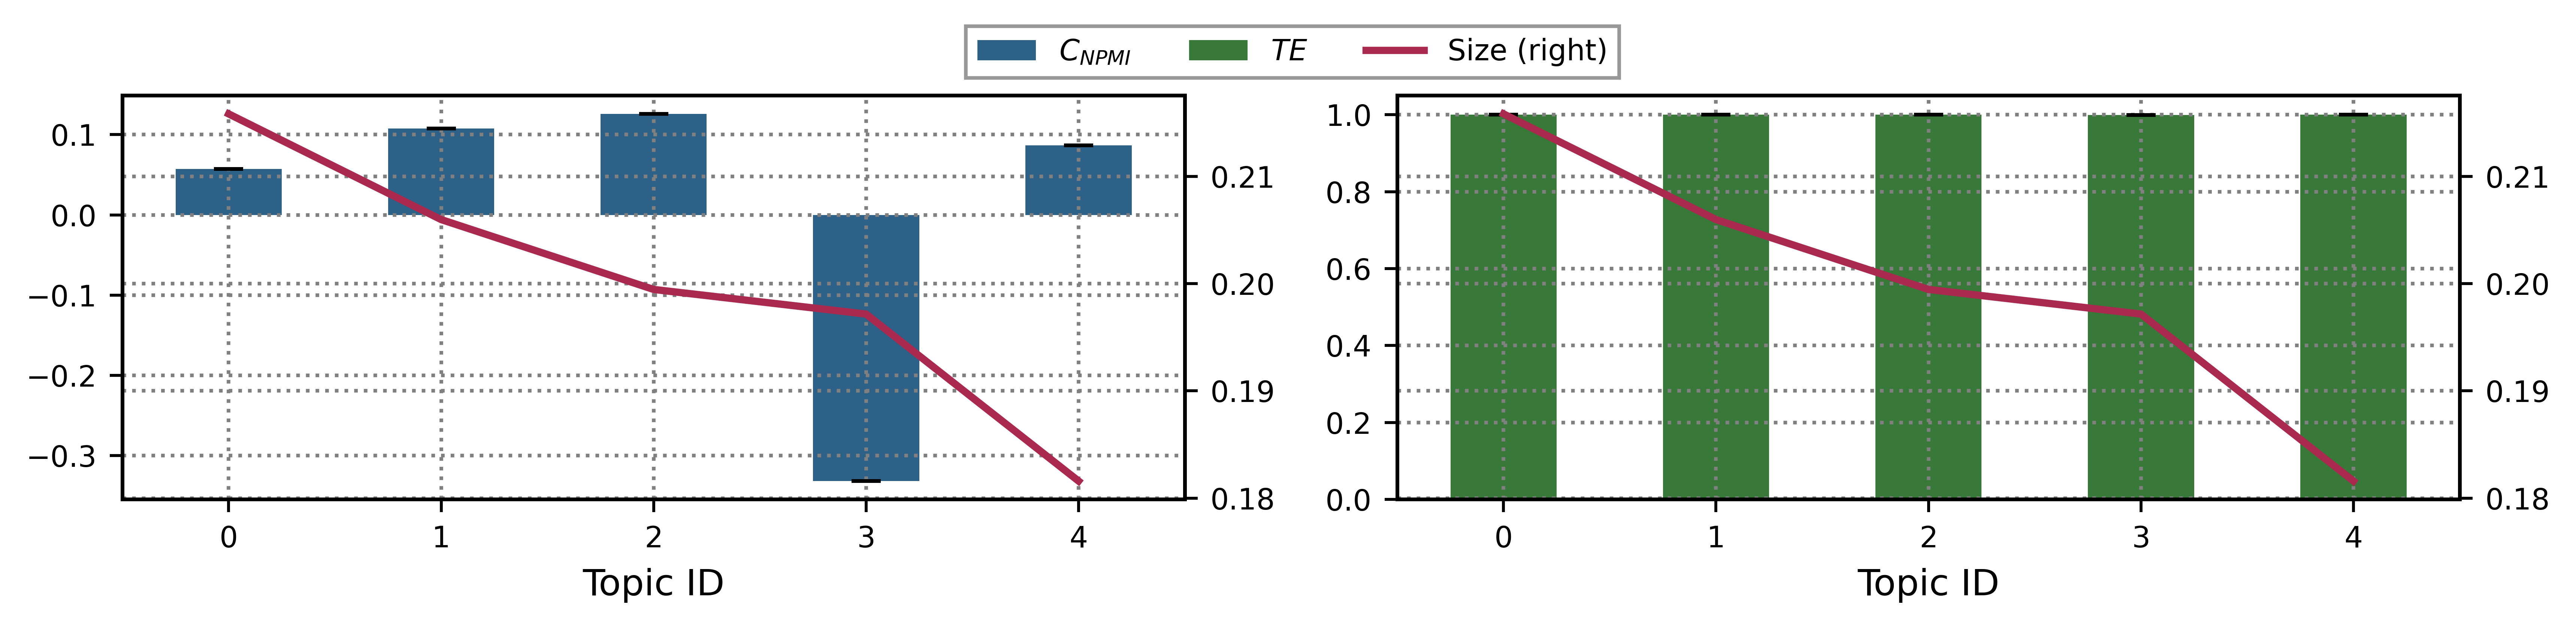

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (11.5, 2)) 
y_repr = ['cohrs_npmi', 'entropies']
y_labels = ['$C_{NPMI}$', '$TE$']
colors = ["#2D6187",  "#387838"] 
labels_all = []
handles_all = []
for yrepr, ylabel, color, ax in zip(y_repr, y_labels, colors, axs.flat):
    
    df_root_plot_ctm.plot.bar(
        ax=ax,
        y=yrepr + "_mean",
        yerr = yrepr + "_var",
        label=ylabel, use_index=True, stacked=True,
        color = color,
        capsize=4)
    ax2 = df_root_plot_ctm.plot(
            ax=ax, 
            y='alphas_mean', kind = 'line', label='Size', color="#A9294F", use_index=True, secondary_y=True)

    ax.grid(True)
    ax.set_xlabel('Topic ID')
    ax2.grid(True)
    ax.get_legend().remove()
    handles, labels = ax.get_legend_handles_labels()
    labels_all += labels
    handles_all += handles

handles2, labels2 = ax2.get_legend_handles_labels()

fig.legend(handles_all+handles2, labels_all+labels2, loc='upper center', ncol=4, bbox_to_anchor=(0.513, 1.04),
           frameon=True, shadow=False)

save_fig = folder_save + "/root_model_" + corpus_name + "_" + model_type + ".png"
fig.savefig(save_fig, dpi='figure', bbox_inches='tight')

In [42]:
df_ctm_root_tpcs = pd.DataFrame(data=df_root_ctm.tpc_descriptions.unique(),
                                   index=range(len(df_root_ctm.tpc_descriptions.unique())),
                                   columns=['Tpc description'])
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       'display.max_colwidth',None
                       ):
    display(df_ctm_root_tpcs)
    display(df_mallet_root_tpcs)

Tpc description
0                physics, quantum, structure, photonic, method, optical, matter, light, physical, computing, spin, electron, frequency, numerical, fundamental
1                                       cell, cancer, human, tumor, protein, drug, disease, tissue, regulation, identify, therapy, dna, genetic, vivo, pathway
2  politic, language, history, society, university, culture, context, migration, policy, perspective, education, case_study, gender, interdisciplinary, school
3              service, platform, management, integrate, support, industry, performance, innovative, datum, sme, demonstrate, improve, smart, resource, design
4      ton, save_million, pesticide, gland, roche, valorisation, mw, golgi_apparatus, oil, insulation, comfort, virtualization, commercialise, enter, additive

Tpc description
0          market, industry, service, manufacture, company, business, customer, safety, sme, software, aircraft, security, waste, operation, smart
1    policy, politic, service, stakeholders, national, innovation, sme, culture, language, governance, theory, public, education, city, healthcare
2                  cell, cancer, patient, protein, therapy, genetic, disease, brain, tumor, vivo, molecule, neuron, drug, tissue, ribonucleic_acid
3  quantum, theory, molecule, physics, photonic, chemistry, electronic, optical, catalysis, magnetic, surface, electron, geometry, image, graphene
4            plant, climate, food, specie, soil, climate_change, genetic, water, crop, biodiversity, agriculture, ocean, forest, ecosystem, genome

## HTM-WS Submodels

In [38]:
df_ws_ctm = df_ctm[df_ctm.thr==0]
df_ws_ctm

iter                                               path  cohrs_cv  \
0      1  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.684647   
0      1  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.636129   
0      1  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.626064   
0      1  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.618439   
0      1  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.610749   
..   ...                                                ...       ...   
0      5  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.605179   
0      5  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.599113   
0      5  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.629184   
0      5  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.623877   
0      5  /export/usuarios_ml4ds/lbartolome/Datasets/COR...  0.663228   

    cohrs_npmi  entropies                  td                 rbo    alphas  \
0    -0.150172   0.999542                 1.0                 1.0  0.200000   
0    -0.052262   0.998862  0.7586666666666667  0.9906956250099107  0.020000   
0    -0.087937   0.999467  0.7044444444444444   0.984918725551494  0.016667   
0    -0.081653   0.998998  0.6733333333333333  0.9883948352084998  0.014286   
0    -0.068749   0.998902  0.6108333333333333  0.9839150114419102  0.012500   
..         ...        ...                 ...                 ...       ...   
0    -0.084089   0.999496  0.7916666666666666  0.9902918484649254  0.025000   
0    -0.033987   0.998546               0.764  0.9914180581323438  0.020000   
0    -0.125240   0.999450  0.9733333333333334  0.9959714729714729  0.200000   
0    -0.076303   0.999029              0.6325  0.9866960658891039  0.012500   
0    -0.139718   0.999594  0.9866666666666667  0.9980109890109891  0.200000   

    tpc_ids  thr  exp_tpc  tr_tpcs  \
0         1  0.0        1        5   
0         1  0.0        1       50   
0         1  0.0        1       60   
0         1  0.0        1       70   
0         3  0.0        3       80   
..      ...  ...      ...      ...   
0         4  0.0        4       40   
0         4  0.0        4       50   
0         1  0.0        1        5   
0         4  0.0        4       80   
0         3  0.0        3        5   

                                     tpc_descriptions  size  
0   [politic, study, history, culture, migration, ...   0.0  
0   [researcher, event, public, activity, place, l...   0.0  
0   [visible, interconnect, cut, concentrate, wide...   0.0  
0   [language, perception, neuron, cognitive, lear...   0.0  
0   [literature, trace, military, heritage, revolu...   0.0  
..                                                ...   ...  
0   [change, climate, ocean, brain, earth, neuron,...   0.0  
0   [market, vehicle, safety, customer, cost, prod...   0.0  
0   [genomic, robot, machine_learning, genetic, ne...   0.0  
0   [device, high, low, area, integration, semicon...   0.0  
0   [industry, produce, production, product, water...   0.0  

[225 rows x 14 columns]

In [39]:
df_ws_ctm_plot = df_ws_ctm.groupby(['exp_tpc', 'tr_tpcs'], as_index=False).apply(my_agg)
df_ws_ctm_plot

exp_tpc  tr_tpcs  cohrs_cv_mean  cohrs_npmi_mean  entropies_mean  \
0         0        5       0.624186        -0.156729        0.999681   
1         0       10       0.621817        -0.143800        0.999526   
2         0       20       0.603262        -0.101662        0.999139   
3         0       30       0.597501        -0.095276        0.999240   
4         0       40       0.587906        -0.093875        0.999093   
5         0       50       0.583134        -0.093291        0.999407   
6         0       60       0.585477        -0.062570        0.998492   
7         0       70       0.591833        -0.085870        0.998963   
8         0       80       0.594356        -0.081278        0.999060   
9         1        5       0.665915        -0.148001        0.999497   
10        1       10       0.662684        -0.120504        0.999447   
11        1       20       0.664292        -0.083087        0.999139   
12        1       30       0.641218        -0.069059        0.998670   
13        1       40       0.633461        -0.068074        0.998800   
14        1       50       0.635594        -0.075721        0.999001   
15        1       60       0.625439        -0.085063        0.998970   
16        1       70       0.622544        -0.083669        0.998980   
17        1       80       0.615288        -0.080411        0.998669   
18        2        5       0.632093        -0.149611        0.999450   
19        2       10       0.654930        -0.128849        0.999427   
20        2       20       0.631656        -0.094012        0.999367   
21        2       30       0.623770        -0.064841        0.999069   
22        2       40       0.603941        -0.049769        0.998356   
23        2       50       0.607407        -0.058671        0.998774   
24        2       60       0.604622        -0.067553        0.998961   
25        2       70       0.604679        -0.069975        0.999053   
26        2       80       0.607087        -0.078531        0.999092   
27        3        5       0.633659        -0.109755        0.999497   
28        3       10       0.621994        -0.081570        0.999376   
29        3       20       0.621494        -0.051187        0.999375   
30        3       30       0.605423        -0.068207        0.999176   
31        3       40       0.605015        -0.064619        0.998769   
32        3       50       0.597421        -0.063082        0.999150   
33        3       60       0.589799        -0.060508        0.998992   
34        3       70       0.600853        -0.074169        0.999194   
35        3       80       0.596411        -0.078405        0.999256   
36        4        5       0.611927        -0.150399        0.999602   
37        4       10       0.621743        -0.105566        0.999305   
38        4       20       0.630332        -0.074180        0.999070   
39        4       30       0.624613        -0.042273        0.998934   
40        4       40       0.613588        -0.070940        0.999159   
41        4       50       0.601956        -0.043037        0.998710   
42        4       60       0.592900        -0.061585        0.998968   
43        4       70       0.603218        -0.041071        0.998867   
44        4       80       0.608154        -0.059487        0.999026   

    alphas_mean   td_mean  rbo_mean  cohrs_cv_var  cohrs_npmi_var  \
0      0.200000  0.994667  0.994923      0.011952        0.015822   
1      0.100000  0.957333  0.994974      0.036099        0.023639   
2      0.050000  0.878000  0.990244      0.012466        0.013711   
3      0.033333  0.812889  0.989982      0.013189        0.014099   
4      0.025000  0.759000  0.989477      0.008783        0.020747   
5      0.020000  0.731467  0.989496      0.019839        0.030669   
6      0.016667  0.668222  0.987804      0.005371        0.005180   
7      0.014286  0.658095  0.988717      0.008884        0.026597   
8      0.012500  0.615833  0.987803      0.007126        0.020340   
9

In [40]:
my_xticks = df_ws_ctm_plot.tr_tpcs.unique().tolist()
my_xticks

[5, 10, 20, 30, 40, 50, 60, 70, 80]

## Final graphs

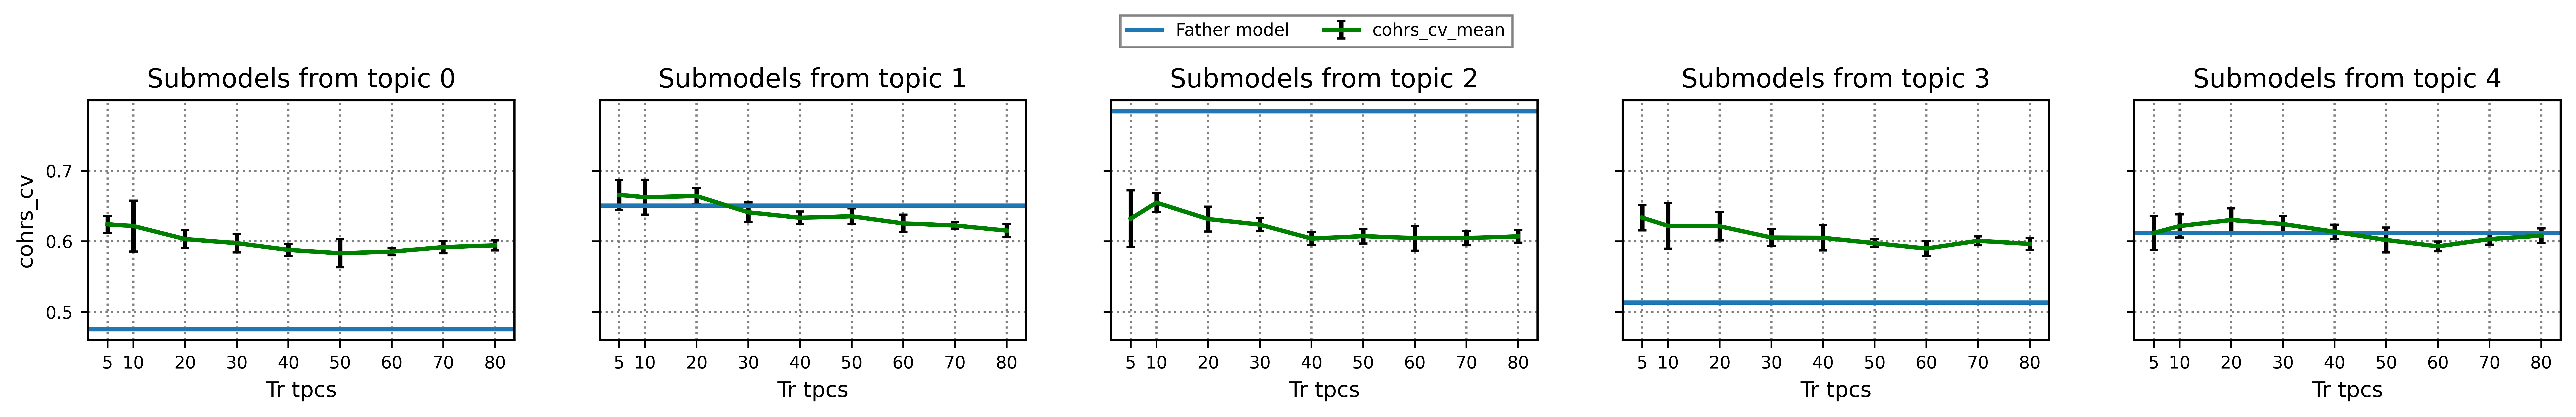

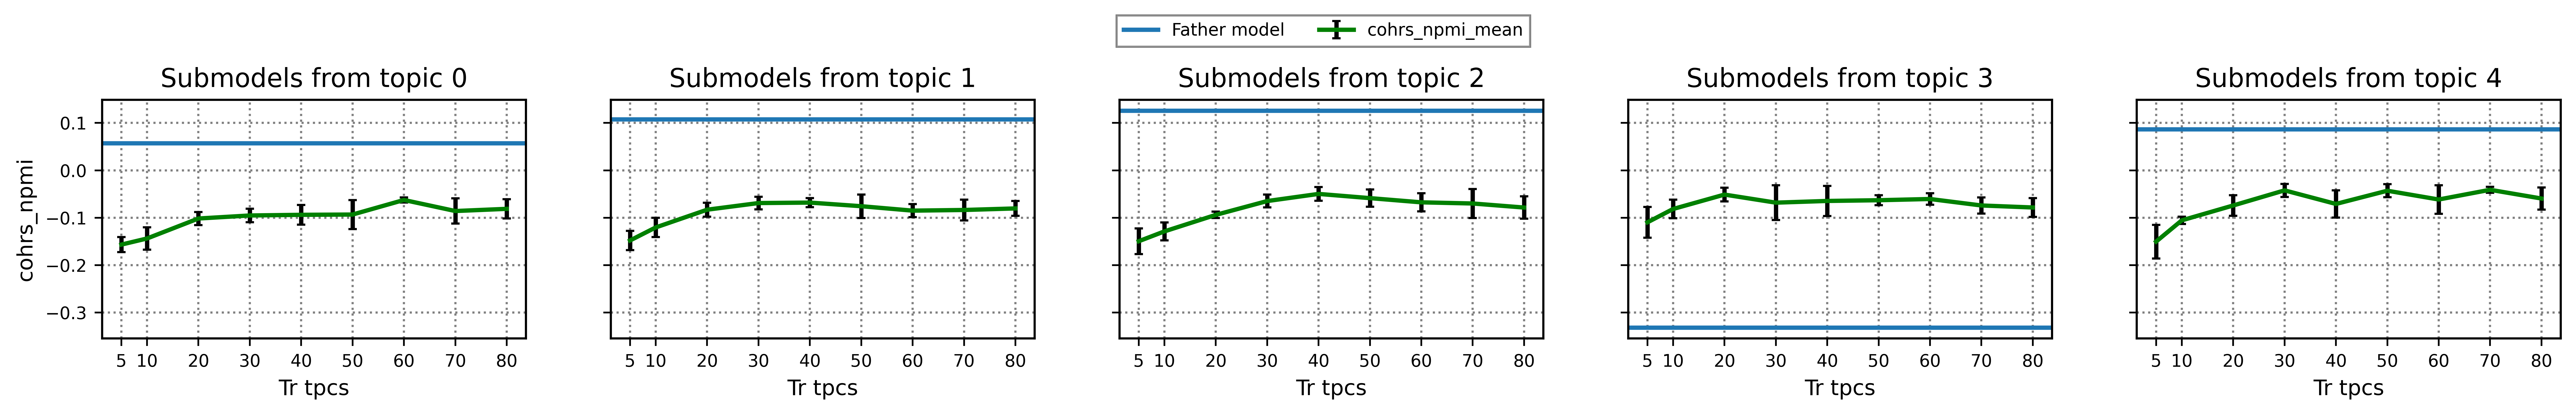

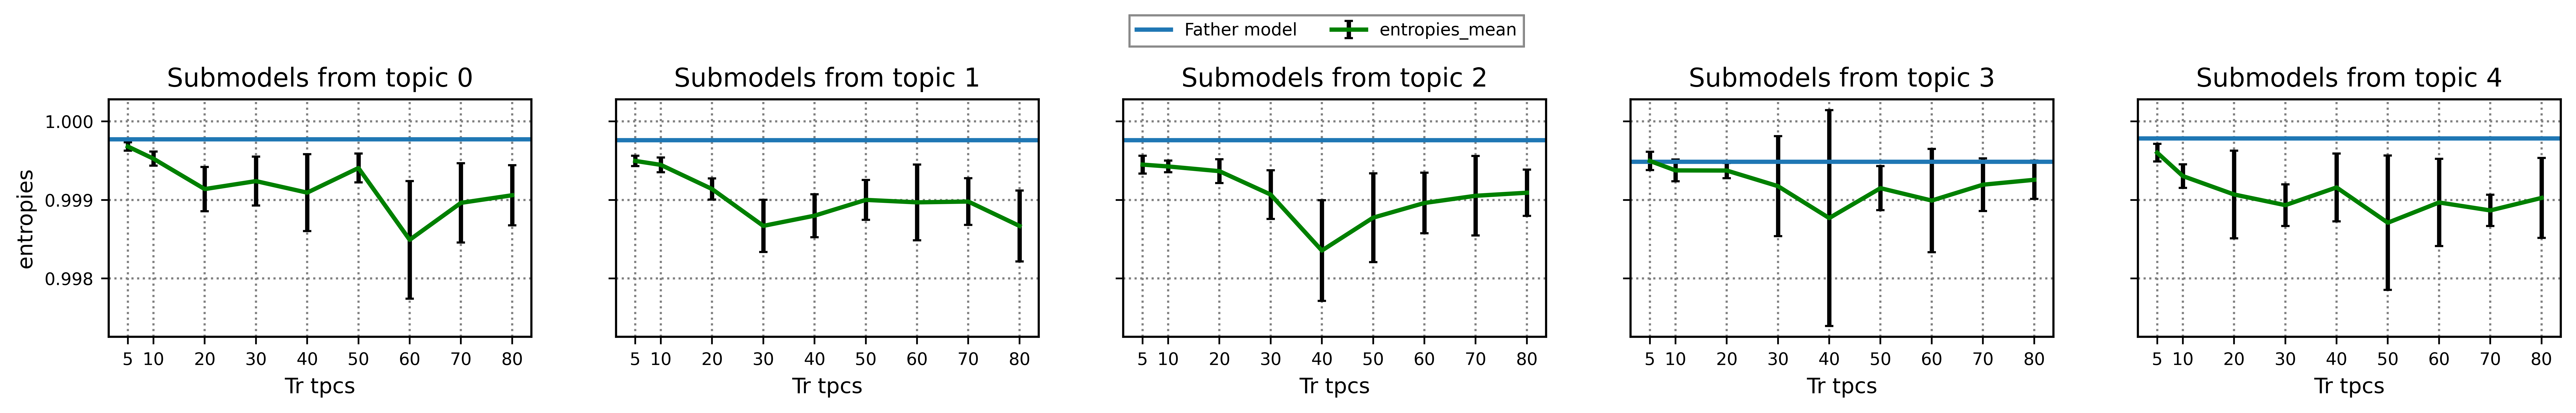

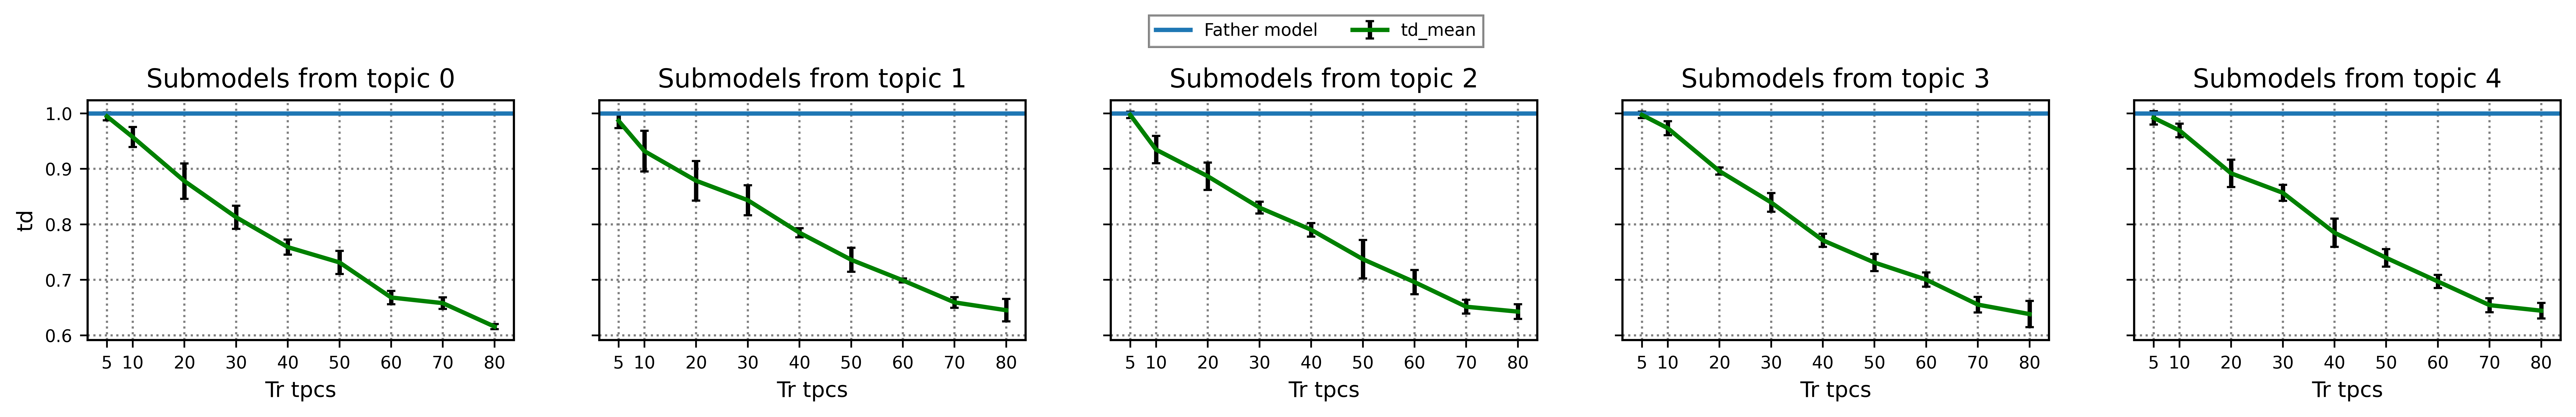

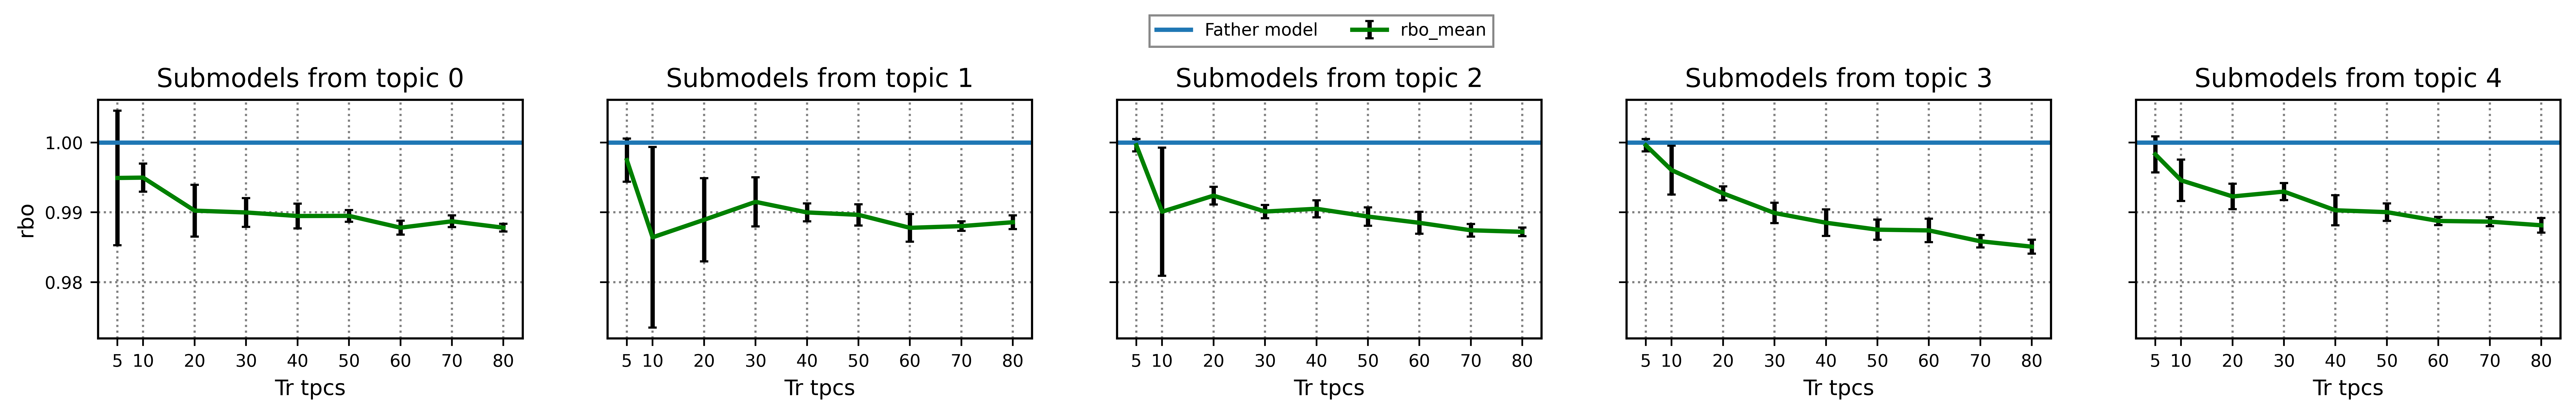

In [41]:
metrics = ['cohrs_cv', 'cohrs_npmi', 'entropies', 'td', 'rbo']
for metric in metrics:
    metric_y = metric + '_mean'
    metric_y_root = metric + '_mean' if metric not in ['td', 'rbo'] else metric
    metric_y_err = metric + '_var'
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize = (20.5, 2), sharex=True, sharey=True) # for 5 topics: (25.5, 4.8)
    for tpc, ax in zip(sorted(df_ws_ctm_plot.exp_tpc.unique()), axs.flat):
        aux = df_ws_ctm_plot[df_ws_ctm_plot.exp_tpc == tpc]
        aux.plot(
            ax=ax,
            x='tr_tpcs',
            y=metric_y,
            yerr=metric_y_err,
            color='green',
            ecolor='black',
            linewidth=2, 
            capsize=2,
            rot=0,
            kind='line'  
        )
        y_ = df_root_plot_ctm[df_root_plot_ctm.tpc_ids==tpc][metric_y_root].values[0]
        if isinstance(y_, np.ndarray):
            y_ = y_.tolist()[0]
        ax.axhline(y=y_, xmin=-1, xmax=len(my_xticks), label='Father model')
        ax.get_legend().remove()
        ax.set_xticks(my_xticks)
        ax.set_xlabel('Tr tpcs')
        ax.set_ylabel(metric)
        ax.set_title(f'Submodels from topic {tpc}')
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.51, 1.18),
                  frameon=True, shadow=False)